# bcolz memory profiling

<a id='go to index'></a>
Index:
  1. <a href='#Profiling carray'>Profiling carray</a>
  -  <a href='#Profiling carray iterators'>Profiling carray iterators</a>

In this part of the tutorial we will make use of the [ipython_memwatcher](https://github.com/FrancescAlted/ipython_memwatcher) to analyze the memory usage of the carray objects compared to Numpy arrays.

Please be aware that measuring memory consumption is a tricky thing, so if you are going to run this section of the notebook several times you might need to restart the IPython kernel.
If you see weird results or get confused, quit IPython and start a fresh shell; then run the fewest commands you need to understand how RAM is being used during the process.

<a id='Profiling carray'></a>
## Profiling carray
<a href='#go to index'>Go to index</a>

In [1]:
from ipython_memwatcher import MemWatcher
import numpy as np
import bcolz
import pandas as pd

In [2]:
N = 1e8
arange_results = {}
mw = MemWatcher()
mw.start_watching_memory()

In [2] used 0.020 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 75.605 MiB


Let's create a couple of big objects:

In [3]:
numpy_array = np.arange(N)

In [3] used 762.973 MiB RAM in 0.390s, peaked 0.000 MiB above current, total RAM usage 838.578 MiB


In [4]:
# Get some measurements from the last executed cell:
arange_results['numpy'] = mw.measurements.memory_delta

In [4] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 838.578 MiB


In [5]:
carray = bcolz.arange(N)

In [5] used 29.145 MiB RAM in 0.793s, peaked 0.000 MiB above current, total RAM usage 867.723 MiB


In [6]:
# Get some measurements from the last executed cell:
arange_results['carray in-memory'] = mw.measurements.memory_delta

In [6] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 867.723 MiB


In [7]:
carray_disk = bcolz.arange(N, rootdir='mydir', mode='w')

In [7] used 1.180 MiB RAM in 0.789s, peaked 0.000 MiB above current, total RAM usage 868.902 MiB


In [8]:
# Get some measurements from the last executed cell:
arange_results['carray on-disk'] = mw.measurements.memory_delta

In [8] used 0.000 MiB RAM in 0.002s, peaked 0.000 MiB above current, total RAM usage 868.902 MiB


{'numpy': 762.97265625, 'carray in-memory': 29.14453125, 'carray on-disk': 1.1796875}


/home/faltet/miniconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2885: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


/home/faltet/miniconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1287: UserWarning: findfont: Font family [u'monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


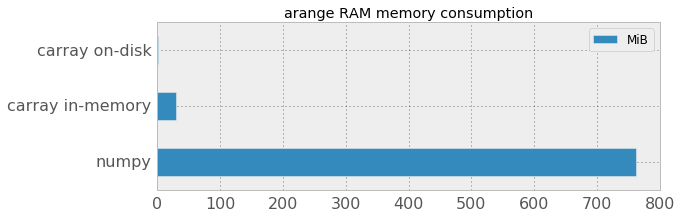

In [9]:
%matplotlib inline
mw.stop_watching_memory()

d = arange_results
print(d)

arange_results_df = pd.DataFrame(arange_results.values(), index=arange_results.keys(), columns=['MiB'])
arange_results_df.plot(kind='barh', figsize=(9,3), fontsize=16, title="arange RAM memory consumption")

In this example, the numpy array consumes aproximately what we would expect ~760 MB  (N items x 8bytes x 2^-20 factor MB). Due to the nature of our data set, default compression does already a pretty neat job, and the ammount of memory required by this object is much smaller, around 26 MB.

But a carray on-disk consumes only 0.2 MB, in this case our data resides on-disk using RAM only to keep references to that object, therefore as you see you can store huge amounts of information while treating them as if they were in-memory, carray on-disk and in-memory support exactly the same set of operations.

Compression ratios will highly depend on your data set, in case your data set would be highly random and you could not get good compression ratios, you could always use carray on disk to use as much less RAM as possible.

<a id='Profiling carray iterators'></a>
## Profiling carray iterators
<a href='#go to index'>Go to index</a>

Let's have a look now at some operations we already saw in this tutorial and check how much memory they actually consume:

In [10]:
sumif_results = {}
mw.start_watching_memory()

In [10] used 29.496 MiB RAM in 0.549s, peaked 0.000 MiB above current, total RAM usage 898.398 MiB


In [11]:
r = sum(v for v in numpy_array if v < 10)

In [11] used 2.227 MiB RAM in 26.273s, peaked 0.000 MiB above current, total RAM usage 900.625 MiB


In [12]:
# Get some measurements from the last executed cell:
sumif_results['numpy'] = mw.measurements.memory_delta

In [12] used 0.113 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 900.738 MiB


In [13]:
r =  sum(v for v in carray if v < 10)

In [13] used 0.910 MiB RAM in 7.825s, peaked 1.625 MiB above current, total RAM usage 901.648 MiB


In [14]:
# Get some measurements from the last executed cell:
sumif_results['carray in-memory'] = mw.measurements.memory_delta

In [14] used 0.000 MiB RAM in 0.001s, peaked 0.000 MiB above current, total RAM usage 901.648 MiB


In [15]:
r =  sum(v for v in carray_disk if v < 10)

In [15] used 0.195 MiB RAM in 7.350s, peaked 1.867 MiB above current, total RAM usage 901.844 MiB


In [16]:
# Get some measurements from the last executed cell:
sumif_results['carray on-disk'] = mw.measurements.memory_delta

In [16] used 0.000 MiB RAM in 0.003s, peaked 0.000 MiB above current, total RAM usage 901.844 MiB


{'numpy': 2.2265625, 'carray in-memory': 0.91015625, 'carray on-disk': 0.1953125}


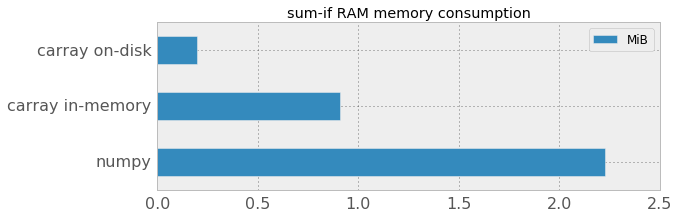

In [17]:
%matplotlib inline
mw.stop_watching_memory()
d = sumif_results
print(d)

sumif_df = pd.DataFrame(d.values(), index=d.keys(), columns=['MiB'])
sumif_df.plot(kind='barh', figsize=(9,3), fontsize=16, title="sum-if RAM memory consumption")

When you iterate `carray` objects, the iterator in this run actually *releases* memory for the in-memory case, whereas the on-disk one does require very little (sometimes negative?), but YMMV.

Again, measuring memory consumption is a tricky thing, so the take
away message is that you should not be afraid of using iterators because they are 1) memory efficient and 2) they are *fast*.

## More about memory and other considerations

If you want more info on other aspects of memory efficiency (and other optimization considerations) of bcolz, you can go to see [some tutorials](https://github.com/FrancescAlted/DataContainersTutorials) that I regularly teach in conferences around the world.